# <B> Setup for SageMaker BYOM examples </B>
* Container: pytorch_p39

## AutoReload

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Set roles

In [57]:
from sagemaker import get_execution_role

In [58]:
strSageMakerRoleName = get_execution_role().rsplit('/', 1)[-1]
print (f"SageMaker Execution Role Name: {strSageMakerRoleName}")

SageMaker Execution Role Name: AmazonSageMaker-ExecutionRole-20221206T163436


### 1.1 Attach IAM polich to sagemaker execution role (<b>with console</b>)
> step 1. IAM console 로 이동    
>
> step 2. 왼쪽 네비게이터에서  "Role" 선택  
> ![nn](images/Role.png)  
>
> step 3. SageMaker Execution Role 검색 후 role 선택 (상위 cell output 참조)  
> ![nn](images/search-by-rolename.png)  
>
> step 4. "attach policies" 메뉴 선택 
> ![nn](images/attach-policy-menu.png)  
>
> step 5. "IAMFullAccess" policy 검색 후 attach 
> ![nn](images/attach-policy.png) 

In [48]:
from utils.iam import iam_handler

In [49]:
iam = iam_handler()

In [50]:
strPrefix = "SM-MLOPS-PIPELINE-"

### 1.2 Attach policy - sagemaker execution role
> SSM  
> S3 <BR>
> CodeCommit <BR>
> CodeBuild <BR>
> CodePipeline <BR>

In [56]:
listPolicyArn=[
    "arn:aws:iam::aws:policy/AmazonSSMFullAccess",
    #"arn:aws:iam::aws:policy/AmazonS3FullAccess",
    "arn:aws:iam::aws:policy/AWSCodeCommitFullAccess",
    "arn:aws:iam::aws:policy/AWSCodeBuildAdminAccess",
    "arn:aws:iam::aws:policy/AWSCodePipeline_FullAccess",
]
for strPolicyArn in listPolicyArn: iam.attach_policy(strSageMakerRoleName, strPolicyArn)

### 1.3 Create role for lambda

In [18]:
listService = ["lambda.amazonaws.com"]
strRoleName = strPrefix + "LabmdaRole"
listPolicyArn = [
    "arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
    "arn:aws:iam::aws:policy/AWSLambda_FullAccess",
    "arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
]
strDescription="Role for Lambda to call SageMaker functions'"

In [19]:
lambdaRoleArn = iam.create_role(
    listService=listService,
    strRoleName=strRoleName,
    listPolicyArn = listPolicyArn,
    strDescription=strDescription
)

== CREATE ROLE ==
  Role Name: [SM-MLOPS-PIPELINE-LabmdaRole] is already exist!!, so, this will be deleted and re-created.
{'ResponseMetadata': {'RequestId': '86069c01-70aa-4a5f-8e49-d732edadaaf0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '86069c01-70aa-4a5f-8e49-d732edadaaf0', 'content-type': 'text/xml', 'content-length': '212', 'date': 'Wed, 05 Apr 2023 05:12:45 GMT'}, 'RetryAttempts': 0}}
arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole
{'ResponseMetadata': {'RequestId': 'd613a521-8be6-4f74-99b6-0913c2340bb6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'd613a521-8be6-4f74-99b6-0913c2340bb6', 'content-type': 'text/xml', 'content-length': '212', 'date': 'Wed, 05 Apr 2023 05:12:45 GMT'}, 'RetryAttempts': 0}}
arn:aws:iam::aws:policy/AmazonSageMakerFullAccess
{'ResponseMetadata': {'RequestId': '29ee5965-1d80-4665-ac3f-e489db432e14', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '29ee5965-1d80-4665-ac3f-e489db432e14', 'content

### 1.4 role-codebuild

In [60]:
listService = ["codebuild.amazonaws.com", "sagemaker.amazonaws.com"]
strRoleName = strPrefix + "CodeBuildRole"
listPolicyArn = [
    "arn:aws:iam::aws:policy/AWSCodeCommitFullAccess",
    "arn:aws:iam::aws:policy/AWSCodeBuildAdminAccess",
    "arn:aws:iam::aws:policy/AmazonS3FullAccess",
    "arn:aws:iam::aws:policy/CloudWatchFullAccess",
    "arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
    "arn:aws:iam::aws:policy/AWSLambda_FullAccess",
    "arn:aws:iam::aws:policy/AmazonSSMFullAccess",
]
strDescription="Role for CodeBuild"

In [61]:
buildRoleArn = iam.create_role(
    listService=listService,
    strRoleName=strRoleName,
    listPolicyArn = listPolicyArn,
    strDescription=strDescription
)
print (f"CODE-BUILD-ROLE-ARN: {buildRoleArn}")

== CREATE ROLE ==
  Role Name: [SM-MLOPS-PIPELINE-CodeBuildRole] is already exist!!, so, this will be deleted and re-created.
{'ResponseMetadata': {'RequestId': '2eb6085d-371a-4954-ac40-a8290f62ebf4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2eb6085d-371a-4954-ac40-a8290f62ebf4', 'content-type': 'text/xml', 'content-length': '212', 'date': 'Wed, 05 Apr 2023 09:05:47 GMT'}, 'RetryAttempts': 0}}
arn:aws:iam::aws:policy/AmazonSSMFullAccess
{'ResponseMetadata': {'RequestId': 'e3b887c6-768a-46a2-9a0b-8774be23b06c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'e3b887c6-768a-46a2-9a0b-8774be23b06c', 'content-type': 'text/xml', 'content-length': '212', 'date': 'Wed, 05 Apr 2023 09:05:47 GMT'}, 'RetryAttempts': 0}}
arn:aws:iam::aws:policy/AWSCodeBuildAdminAccess
{'ResponseMetadata': {'RequestId': '17a614f8-06b2-4e75-8ea0-27ec79d1d854', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '17a614f8-06b2-4e75-8ea0-27ec79d1d854', 'content-type': 'text/xml', 

### 1.5 role-codepipeline

In [43]:
listService = ["codepipeline.amazonaws.com", "codebuild.amazonaws.com"]
strRoleName = strPrefix + "CodePipelineRole"
listPolicyArn = [
    "arn:aws:iam::aws:policy/AWSCodeCommitFullAccess",
    "arn:aws:iam::aws:policy/AmazonS3FullAccess",
    "arn:aws:iam::aws:policy/AWSCodeBuildAdminAccess",
    "arn:aws:iam::aws:policy/AWSCodeDeployFullAccess",
    "arn:aws:iam::aws:policy/AWSCodePipeline_FullAccess"
]
strDescription="Role for CodePipeline"

In [44]:
pipelineRoleArn = iam.create_role(
    listService=listService,
    strRoleName=strRoleName,
    listPolicyArn = listPolicyArn,
    strDescription=strDescription
)

print (f"CODE-PIPELINE-ROLE-ARN: {pipelineRoleArn}")

== CREATE ROLE ==
  Service name: ['codepipeline.amazonaws.com', 'codebuild.amazonaws.com'], 
  Role name: SM-MLOPS-PIPELINE-CodePipelineRole, 
  Policys: ['arn:aws:iam::aws:policy/AWSCodeCommitFullAccess', 'arn:aws:iam::aws:policy/AmazonS3FullAccess', 'arn:aws:iam::aws:policy/AWSCodeBuildAdminAccess', 'arn:aws:iam::aws:policy/AWSCodeDeployFullAccess', 'arn:aws:iam::aws:policy/AWSCodePipeline_FullAccess'], 
  Role ARN: arn:aws:iam::419974056037:role/SM-MLOPS-PIPELINE-CodePipelineRole
== COMPLETED ==
CODE-PIPELINE-ROLE-ARN: arn:aws:iam::419974056037:role/SM-MLOPS-PIPELINE-CodePipelineRole


## 2. Set default parameters

In [45]:
import boto3
import sagemaker
from utils.ssm import parameter_store

In [46]:
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)

In [59]:
pm.put_params(key="PREFIX", value=strPrefix, overwrite=True)
pm.put_params(key="".join([strPrefix, "REGION"]), value=strRegionName, overwrite=True)
pm.put_params(key="".join([strPrefix, "BUCKET"]), value=sagemaker.Session().default_bucket(), overwrite=True)
pm.put_params(key="".join([strPrefix, "SAGEMAKER-ROLE-ARN"]), value=get_execution_role(), overwrite=True)
pm.put_params(key="".join([strPrefix, "ACCOUNT-ID"]), value=boto3.client("sts").get_caller_identity().get("Account"), overwrite=True)
pm.put_params(key=strPrefix + "LAMBDA-ROLE-ARN", value=lambdaRoleArn, overwrite=True)
pm.put_params(key=strPrefix + "CODE-BUILD-ROLE-ARN", value=buildRoleArn, overwrite=True)
pm.put_params(key=strPrefix + "CODE-PIPELINE-ROLE-ARN", value=pipelineRoleArn, overwrite=True)


'Store suceess'

## 3. Data preparation
* https://sagemaker-examples.readthedocs.io/en/latest/aws_sagemaker_studio/frameworks/pytorch_cnn_cifar10/pytorch_cnn_cifar10.html
* The CIFAR-10 dataset is a subset of the 80 million tiny images dataset. It consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

In [24]:
! wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
! tar xfvz cifar-10-python.tar.gz
! mkdir data
! mv cifar-10-batches-py data/.
! rm cifar-10-python.tar.gz

--2023-04-05 05:13:09--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

100%[======================================>] 170,498,071 79.3MB/s   in 2.0s   

2023-04-05 05:13:12 (79.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


### 3.1 preview

In [25]:
from utils.cifar_utils import classes, show_img, train_data_loader, test_data_loader
train_loader = train_data_loader()
test_loader = test_data_loader()

    horse     plane      ship      deer


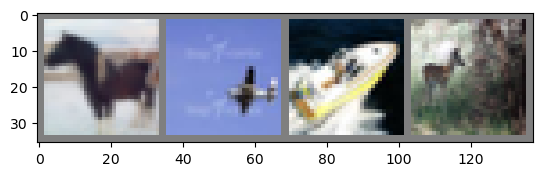

In [26]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(train_loader)
images, labels = next(iter(dataiter))

# show images
show_img(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

### 3.2 upload to S3

In [27]:
from utils.s3 import s3_handler

In [28]:
s3 = s3_handler()

This is a S3 handler with [None] region.


In [29]:
source_dir, target_bucket, target_dir = "data", pm.get_params(key=strPrefix+"BUCKET"), "data"
s3.upload_dir(source_dir, target_bucket, target_dir)

Upload:[data] was uploaded to [s3://sagemaker-us-east-1-419974056037/data]successfully


In [30]:
pm.put_params(key="".join([strPrefix, "DATA-PATH"]), value=f"s3://{target_bucket}/{target_dir}", overwrite=True)

'Store suceess'

In [31]:
print (f'input data: {pm.get_params(key=strPrefix + "DATA-PATH")}')

input data: s3://sagemaker-us-east-1-419974056037/data


In [34]:
pm.get_params(key=strPrefix+"BUCKET")

'sagemaker-us-east-1-419974056037'